In [1]:
# Load in necessary packages
# general packages for data wrangling and plot
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.patches as mpatches
import seaborn as sb
sb.set_style("darkgrid")
# data pre-processing packages
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer
# performance evaluation packages
from sklearn import metrics
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, StratifiedKFold, RepeatedStratifiedKFold, learning_curve, train_test_split
# model building packages
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')

import timeit


# Load Data

In [41]:
#read data file
#stroke = pd.read_csv("healthcare-dataset-stroke-data.csv", thousands=',')
stroke = pd.read_csv("https://raw.githubusercontent.com/ACM40960/project-dyu-ucd/main/healthcare-dataset-stroke-data.csv", thousands=',')
stroke.drop('id', axis = 1, inplace = True)
start_time = timeit.default_timer()

# Exploratory Data Analysis

## General information of the stroke dataset

In [42]:
#show no of rows, columns, data type
print(stroke.shape)
print(stroke.dtypes)
print(stroke.isnull().sum())

(5110, 11)
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


## Number of observations by categorical variables

<Figure size 432x288 with 0 Axes>

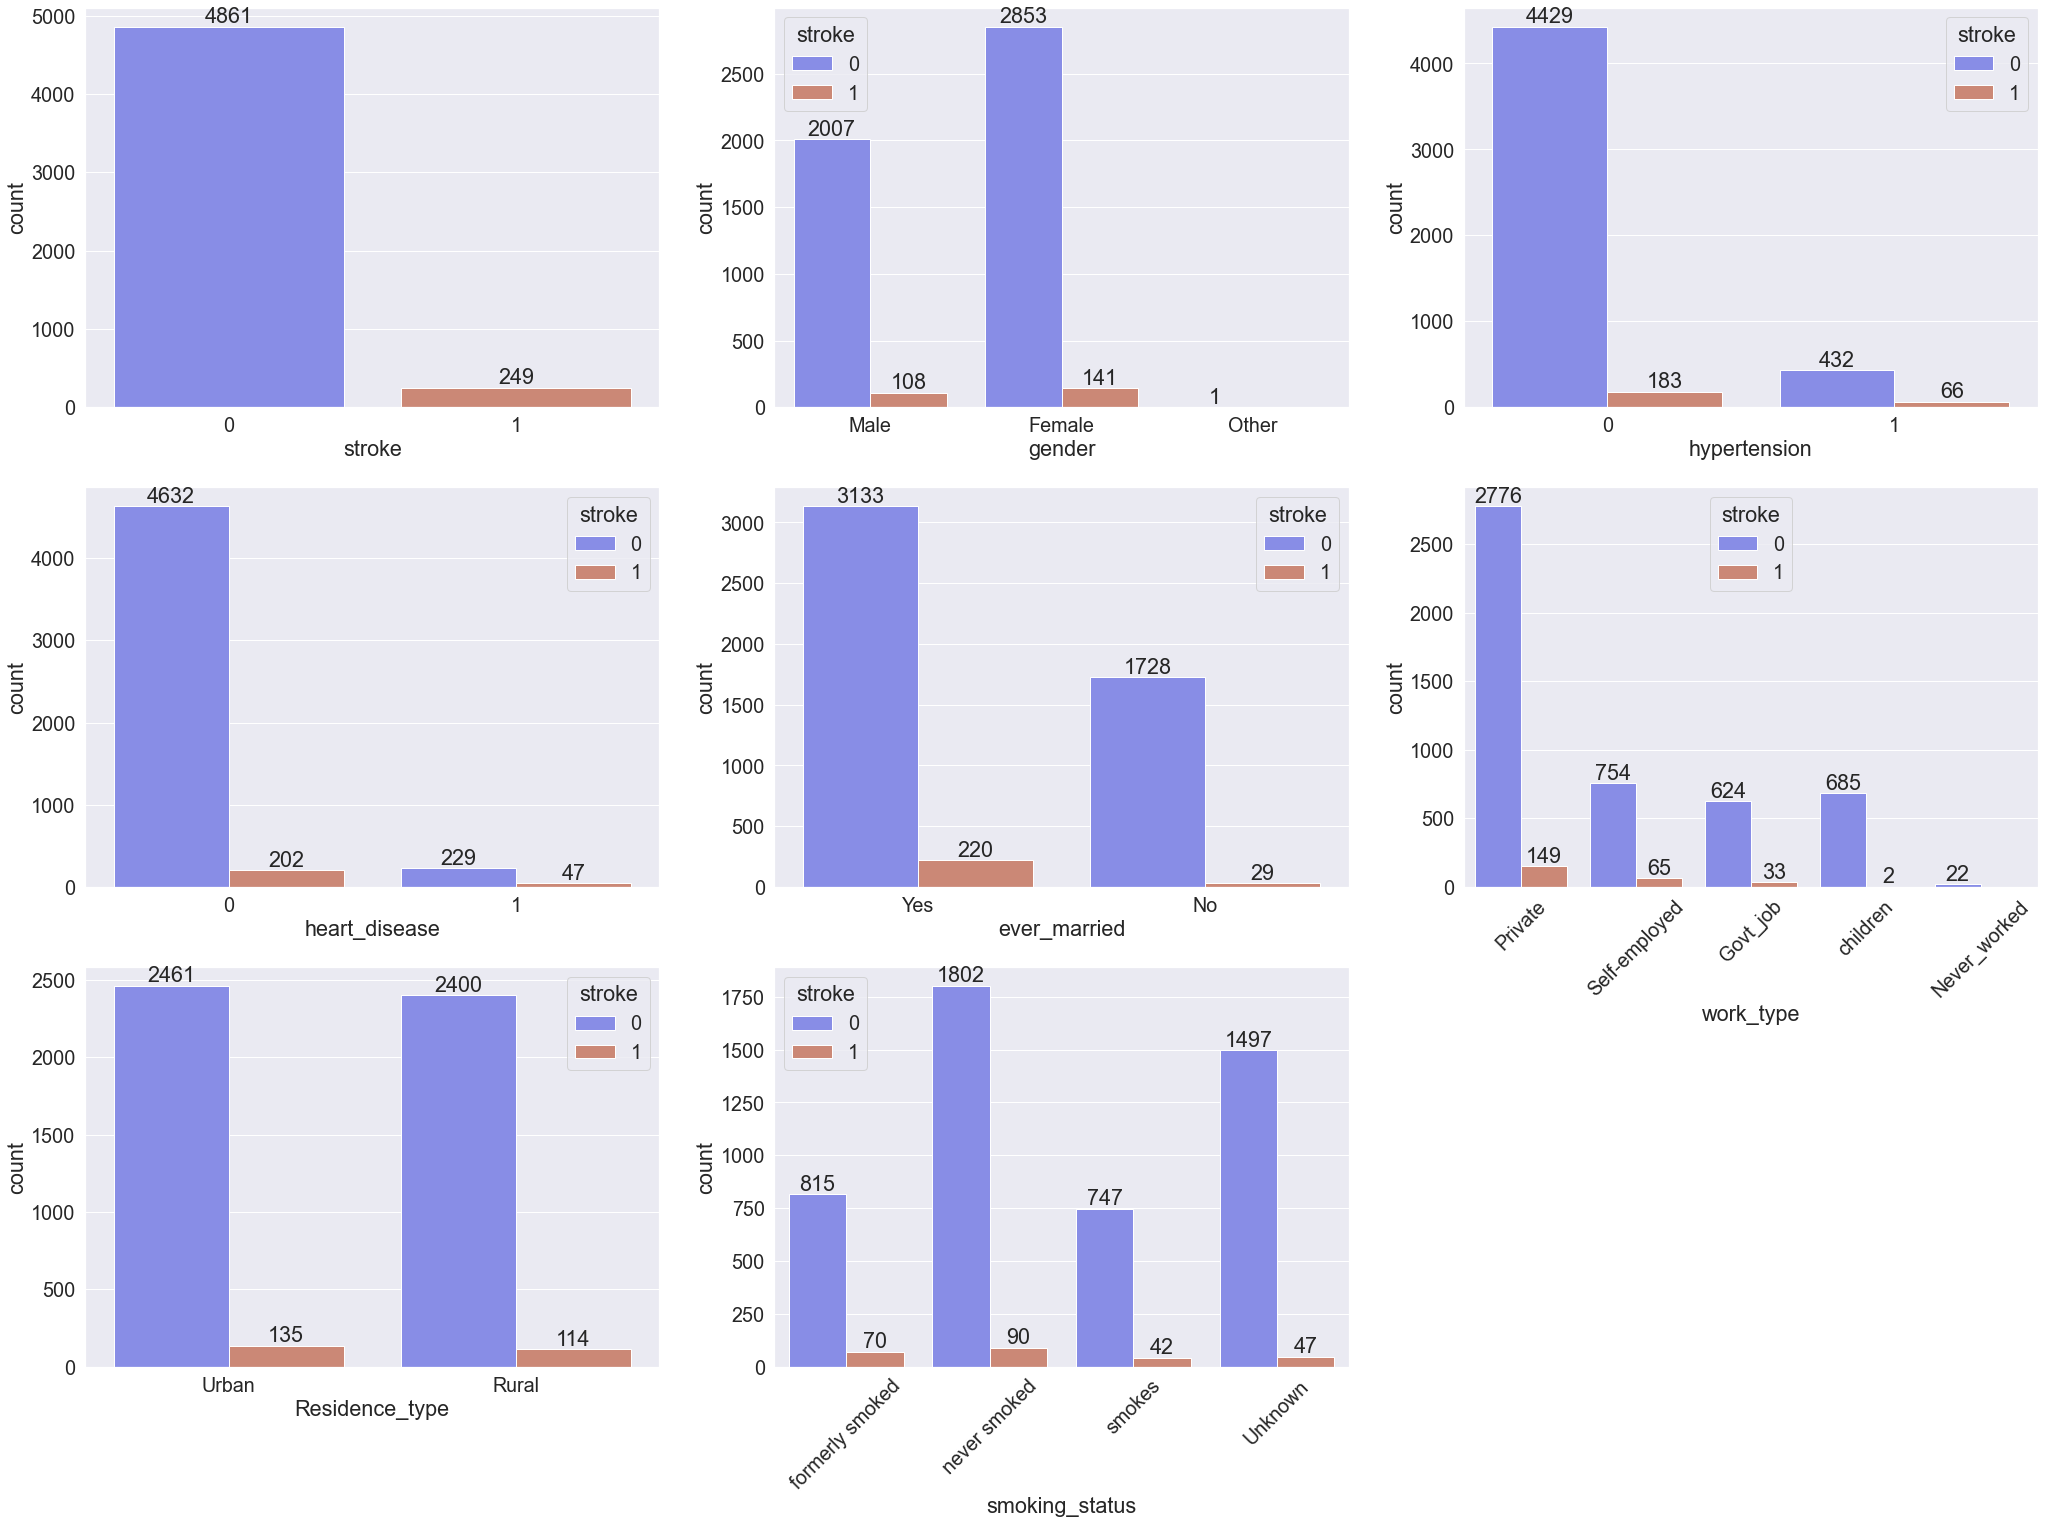

In [4]:
#get all cat variables
cat_var = ['stroke','gender','hypertension','heart_disease','ever_married','work_type','Residence_type','smoking_status']

sb.despine(bottom = True, left = True)
sb.set(font_scale=1.8)
color = ['#787FF6','#D98068']
fig, axes = plt.subplots(3, 3, figsize=(35, 25))

i=0
j=0

for v in cat_var:
    if v == 'stroke':
        plot = sb.countplot(x='stroke', data=stroke, ax=axes[0,0],palette=color)
    else:
        plot = sb.countplot(x=v, hue='stroke', data=stroke, ax=axes[i,j], palette=color)
    
    #add number to the label
    for container in plot.containers:
        plot.bar_label(container)
    
    #formatting - rotate long label of x axis
    if v in ['work_type','smoking_status']:
        plt.setp(plot.get_xticklabels(), rotation=45)
        
    #set position of plot in the grid
    j = j+1
    if j == 3:
        j = 0
        i = i+1
  
axes.flat[-1].set_visible(False)

## Distribution of continuous variables

<AxesSubplot:xlabel='stroke', ylabel='avg_glucose_level'>

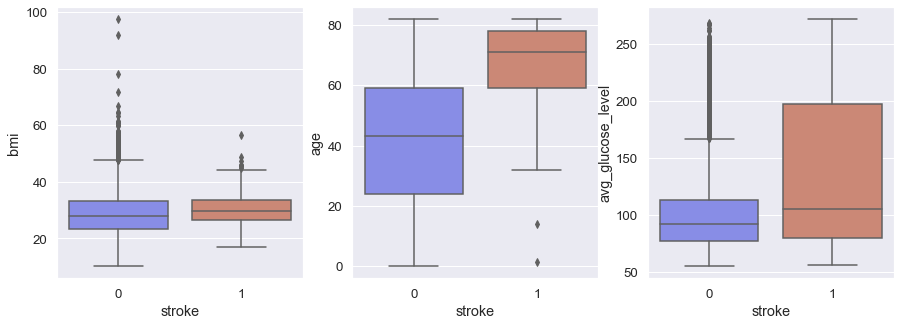

In [5]:
#Boxplot by stroke - continuous variables
sb.set(font_scale=1.2)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sb.boxplot(x="stroke", y="bmi", data=stroke, ax=axes[0],palette=color)
sb.boxplot(x="stroke", y="age", data=stroke, ax=axes[1],palette=color)
sb.boxplot(x="stroke", y="avg_glucose_level", data=stroke, ax=axes[2], palette=color)

## Correlation between variables

<AxesSubplot:>

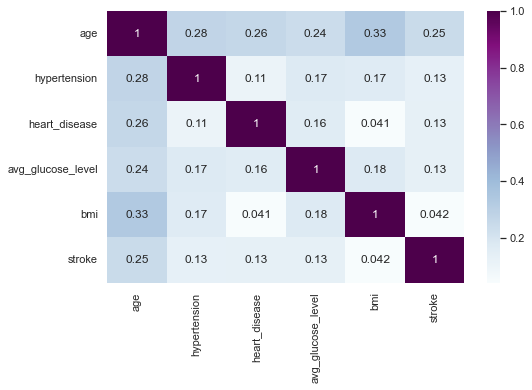

In [6]:
#correlation matrix of all variables (remove id from the plot)
sb.set(rc={'figure.figsize':(8,5)})
sb.heatmap(stroke.corr(), annot=True, cmap="BuPu")

# Data Pre-processing

## Drop outliers

In [7]:
#get only numeric columns and calculate z-score
num_var = ["age", "bmi", "avg_glucose_level"]
stroke_num = stroke[num_var]
stroke_std = (stroke_num-stroke_num.mean())/stroke_num.std()

#default flag to keep row
stroke['keep'] = 1
#flag columns to remove if any numeric columns has z-score > 3 (outlier)
stroke.iloc[stroke_std[(np.abs(stroke_std)>3).any(1)].index,-1] = 0
stroke = stroke[stroke['keep']==1]
#drop temp column - keep
stroke.drop('keep', axis=1, inplace=True)

In [8]:
# drop "other" with unique category in gender 
stroke.drop(stroke[stroke.gender == 'Other'].index, axis = 0, inplace=True)
stroke.shape
stroke['stroke'].value_counts()

0    4763
1     239
Name: stroke, dtype: int64

## Split Train/Test Set 

In [9]:
seed = 913
#split independent variables
X = stroke.drop('stroke', axis=1)
#response variable
y = stroke['stroke']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=seed)

## Categorical Variable Encoding

In [10]:
cat_var = ['gender','ever_married','work_type','Residence_type','smoking_status']
for c in cat_var:
    X_train[c]=X_train[c].astype('category')
    X_train[c+'_new']=X_train[c].cat.codes
    X_test[c]=X_train[c].astype('category')
    X_test[c+'_new']=X_train[c].cat.codes

cat_new = X_train.columns[X_train.columns.str.contains('_new') == True].tolist()
onehot_encoder = OneHotEncoder()
transformed_train = onehot_encoder.fit_transform(X_train[cat_new])
transformed_test = onehot_encoder.fit_transform(X_test[cat_new])

X_train = X_train.drop(cat_var, axis =1)
X_test = X_test.drop(cat_var, axis = 1)

#To check categorical variables are encoded
X_train.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_new,ever_married_new,work_type_new,Residence_type_new,smoking_status_new
1048,57.0,0,1,76.50,29.2,1,1,2,1,1
1771,47.0,0,0,56.67,24.4,0,1,2,1,2
2241,5.0,0,0,73.69,24.8,0,0,4,0,0
125,72.0,0,0,131.41,28.4,0,1,0,1,2
4095,57.0,0,0,106.84,29.6,0,1,3,1,2


## Standardization 

In [11]:
stdSc = StandardScaler()
train_std = stdSc.fit_transform(X_train[num_var])
X_train[num_var] = pd.DataFrame(train_std,columns = X_train[num_var].columns, index=X_train[num_var].index)
X_test[num_var] = pd.DataFrame(stdSc.transform(X_test[num_var]),columns = X_test[num_var].columns, index=X_test[num_var].index)

## Impute missing Data

In [12]:
imputer = KNNImputer()
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns, index=X_test.index)

## Resampling


Logistic Regression

Accuracy: 0.94
AUC under ROC: 0.85
AUC under Precison_Recall:0.22
F1: 0.0
F2: 0.0


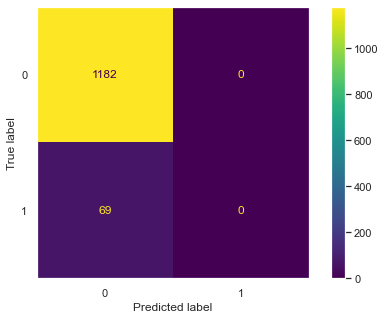

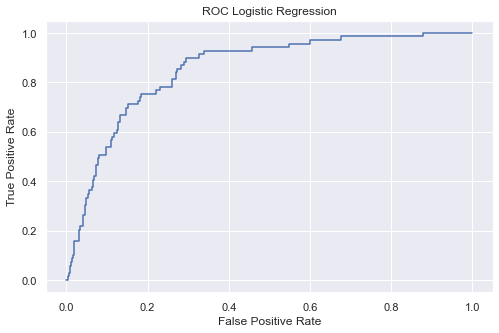

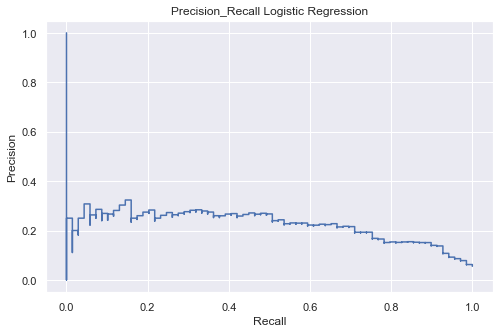

In [13]:
# Before resampling, apply logistic regression model to see how it works
lg = LogisticRegression(random_state = seed)
lg.fit(X_train, y_train)
y_pred = lg.predict(X_test)

# Pre defined function to print classifier performance
def confusion_matrix( y_test, y_pred):
    cm = metrics.confusion_matrix(y_test, y_pred)
    cm_display = ConfusionMatrixDisplay(cm).plot()
    plt.grid()

    
def ROC_Curve(clf,classifier_text, X_test, y_test, y_pred):
    if clf == lg:
        y_score = clf.decision_function(X_test)
    else:
        y_score = clf.predict_proba(X_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test, y_score, pos_label= clf.classes_[1])
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    auc = metrics.roc_auc_score(y_test, y_score)
    plt.title("ROC " + classifier_text)
    print("\n" + classifier_text + "\n")
    print("Accuracy: " + str(round(metrics.accuracy_score(y_test, y_pred),2)))
    print("AUC under ROC: " + str(round(auc,2)))

def Precision_Recall(clf, classifier_text, X_test, y_test, y_pred):
    if clf == lg:
        y_score = clf.decision_function(X_test)
    else:
        y_score = clf.predict_proba(X_test)[::,1]
    prec, recall, _ = precision_recall_curve(y_test, y_score, pos_label=clf.classes_[1])
    pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()
    plt.title("Precision_Recall " + classifier_text)
    #f-measure balanced weight
    f1 = metrics.f1_score(y_test, y_pred)
    #f-measure beta=2 weight more on recall
    f2 = metrics.fbeta_score(y_test, y_pred, beta=2)
    print("AUC under Precison_Recall:"+str(round(metrics.auc(recall, prec),2)))
    print("F1: " + str(round(f1,2)))
    print("F2: " + str(round(f2,2)))
    
confusion_matrix(y_test, y_pred)
ROC_Curve(lg, "Logistic Regression", X_test, y_test, y_pred)
Precision_Recall(lg, "Logistic Regression", X_test, y_test, y_pred)


### Undersampling

In [14]:
from imblearn.under_sampling import RandomUnderSampler

randomUS = RandomUnderSampler(random_state = seed)
X_us, y_us = randomUS.fit_resample(X_train, y_train)
y_us.value_counts()

0    170
1    170
Name: stroke, dtype: int64


Logistic Regression with Undersampling

Accuracy: 0.73
AUC under ROC: 0.85
AUC under Precison_Recall:0.21
F1: 0.26
F2: 0.44


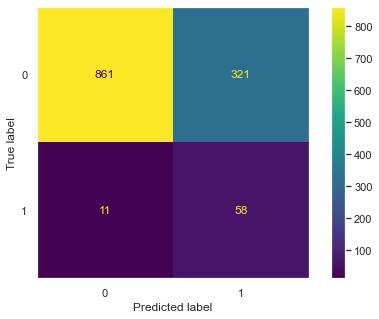

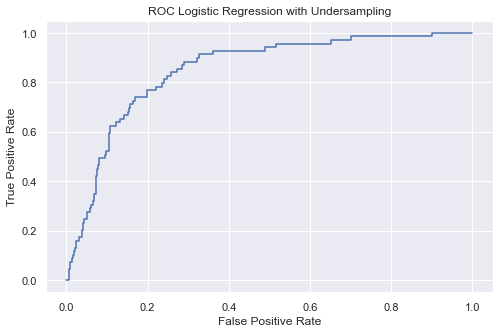

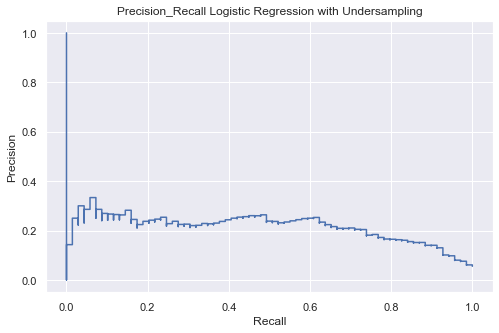

In [15]:
#Observe fit result with logistic regression
lg = LogisticRegression(random_state = seed)
lg.fit(X_us, y_us)
y_pred = lg.predict(X_test)

confusion_matrix(y_test, y_pred)
ROC_Curve(lg, "Logistic Regression with Undersampling", X_test, y_test, y_pred)
Precision_Recall(lg, "Logistic Regression with Undersampling", X_test, y_test, y_pred)

### Oversampling

In [16]:
#Method1 regular oversampling
from imblearn.over_sampling import RandomOverSampler
randomOS = RandomOverSampler(random_state = seed)
X_os, y_os = randomOS.fit_resample(X_train, y_train)
y_os.value_counts()

0    3581
1    3581
Name: stroke, dtype: int64


Logistic Regression with Oversampling

Accuracy: 0.74
AUC under ROC: 0.85
AUC under Precison_Recall:0.21
F1: 0.25
F2: 0.43


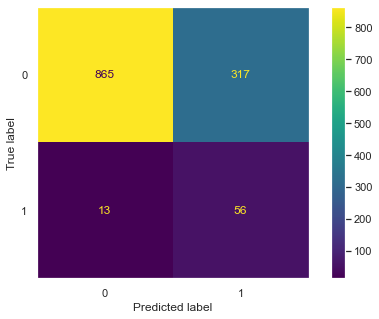

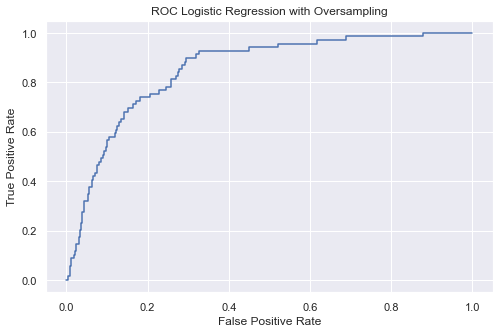

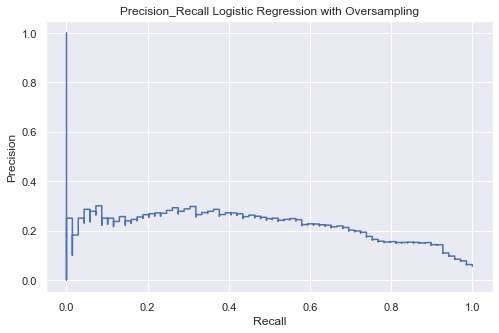

In [17]:
#Observe fit result with logistic regression
lg = LogisticRegression(random_state = seed)
lg.fit(X_os, y_os)
y_pred = lg.predict(X_test)

confusion_matrix(y_test, y_pred)
ROC_Curve(lg, "Logistic Regression with Oversampling", X_test, y_test, y_pred)
Precision_Recall(lg, "Logistic Regression with Oversampling", X_test, y_test, y_pred)

In [18]:
#Method2 - SMOTE
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=seed)
X_synth, y_synth = sm.fit_resample(X_train, y_train)
y_synth.value_counts()

0    3581
1    3581
Name: stroke, dtype: int64


Logistic Regression with SMOTE

Accuracy: 0.74
AUC under ROC: 0.85
AUC under Precison_Recall:0.22
F1: 0.26
F2: 0.44


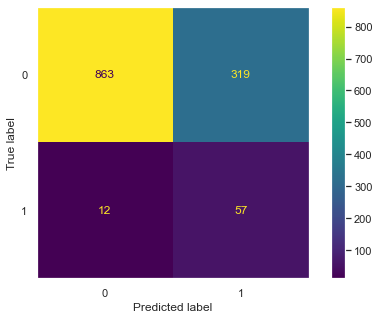

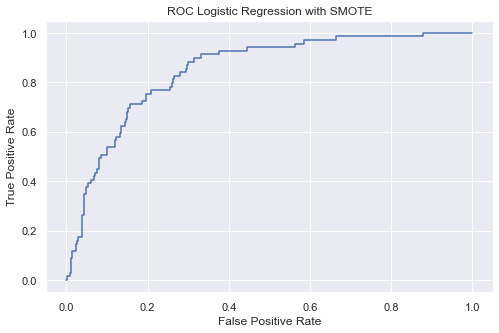

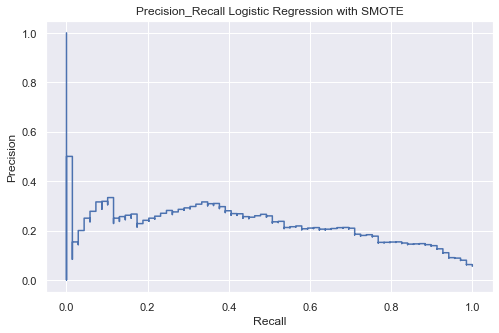

In [19]:
lg = LogisticRegression(random_state = seed)
lg.fit(X_synth, y_synth)
y_pred = lg.predict(X_test)

confusion_matrix(y_test, y_pred)
ROC_Curve(lg, "Logistic Regression with SMOTE", X_test, y_test, y_pred)
Precision_Recall(lg, "Logistic Regression with SMOTE", X_test, y_test, y_pred)

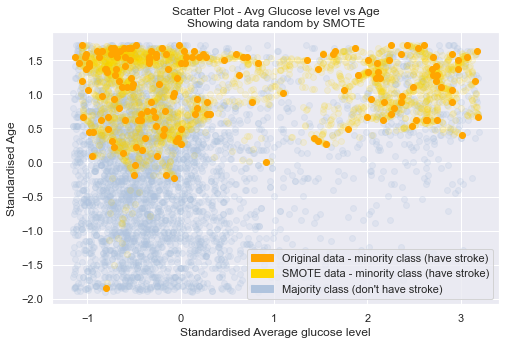

In [20]:
#Plot show how SMOTE works
X_train_0 = X_train[y_train==0]
X_train_1 = X_train[y_train==1]
X_synth_1 = X_synth[y_synth==1]
#plot scatter
plt.scatter(X_train_0['avg_glucose_level'], X_train_0['age'], alpha=0.2, c='lightsteelblue')
plt.scatter(X_synth_1['avg_glucose_level'], X_synth_1['age'], alpha=0.1, c='gold')
plt.scatter(X_train_1['avg_glucose_level'], X_train_1['age'], c='orange')
#plot format
plt.title("Scatter Plot - Avg Glucose level vs Age\nShowing data random by SMOTE")
plt.xlabel("Standardised Average glucose level")
plt.ylabel("Standardised Age")
legend1 = mpatches.Patch(color='orange', label='Original data - minority class (have stroke)')
legend2 = mpatches.Patch(color='gold', label='SMOTE data - minority class (have stroke)')
legend3 = mpatches.Patch(color='lightsteelblue', label='Majority class (don\'t have stroke)')
plt.legend(handles=[legend1, legend2, legend3])

In [21]:
#Method3 - SMOTENC
from imblearn.over_sampling import SMOTENC

sm = SMOTENC([1],random_state=seed)
X_synthnc, y_synthnc = sm.fit_resample(X_train, y_train)
y_synthnc.value_counts()

0    3581
1    3581
Name: stroke, dtype: int64


Logistic Regression with SMOTENC

Accuracy: 0.74
AUC under ROC: 0.84
AUC under Precison_Recall:0.22
F1: 0.26
F2: 0.44


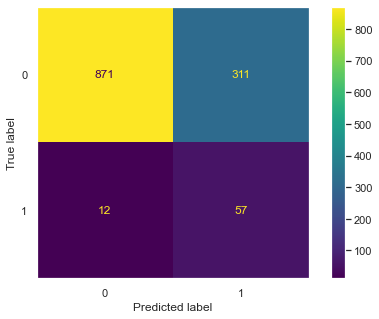

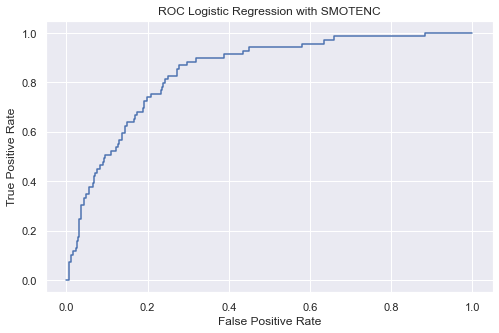

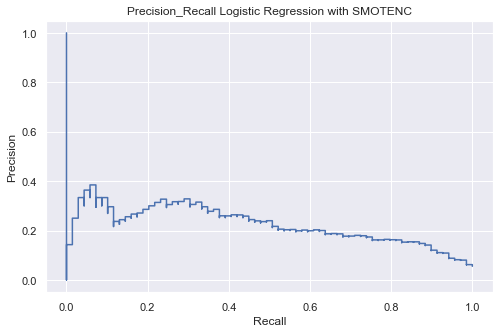

In [22]:
lg = LogisticRegression(random_state = seed)
lg.fit(X_synthnc, y_synthnc)
y_pred = lg.predict(X_test)

confusion_matrix(y_test, y_pred)
ROC_Curve(lg, "Logistic Regression with SMOTENC", X_test, y_test, y_pred)
Precision_Recall(lg, "Logistic Regression with SMOTENC", X_test, y_test, y_pred)

In [23]:
#Method4 - BorderlineSMOTE
from imblearn.over_sampling import BorderlineSMOTE

bsmote = BorderlineSMOTE(random_state = seed, kind = 'borderline-1')
X_synthb, y_synthb = bsmote.fit_resample(X_train, y_train)
y_synthb.value_counts()

0    3581
1    3581
Name: stroke, dtype: int64


Logistic Regression with BorderlineSMOTE

Accuracy: 0.77
AUC under ROC: 0.85
AUC under Precison_Recall:0.21
F1: 0.27
F2: 0.45


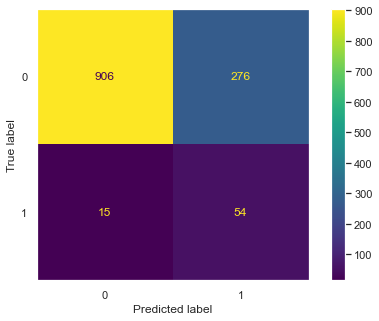

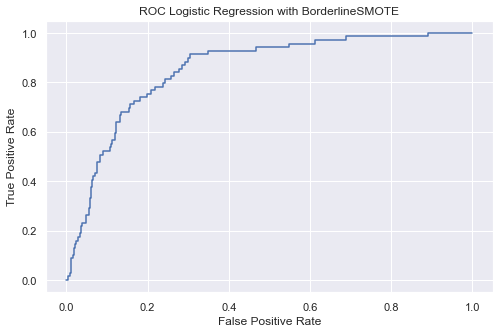

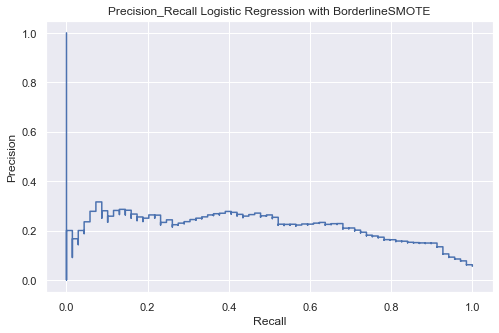

In [24]:
lg = LogisticRegression(random_state = seed)
lg.fit(X_synthb, y_synthb)
y_pred = lg.predict(X_test)

confusion_matrix(y_test, y_pred)
ROC_Curve(lg, "Logistic Regression with BorderlineSMOTE", X_test, y_test, y_pred)
Precision_Recall(lg, "Logistic Regression with BorderlineSMOTE", X_test, y_test, y_pred)

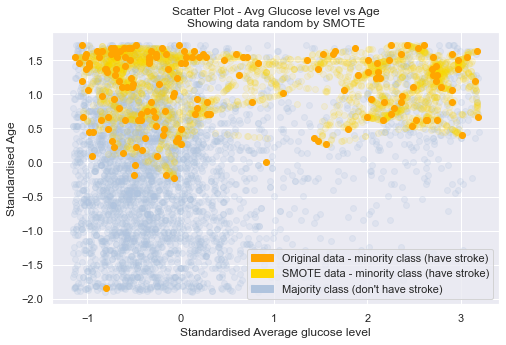

In [25]:
#Plot show how SMOTE works
X_train_0 = X_train[y_train==0]
X_train_1 = X_train[y_train==1]
X_synth_1 = X_synthb[y_synthb==1]
#plot scatter
plt.scatter(X_train_0['avg_glucose_level'], X_train_0['age'], alpha=0.2, c='lightsteelblue')
plt.scatter(X_synth_1['avg_glucose_level'], X_synth_1['age'], alpha=0.1, c='gold')
plt.scatter(X_train_1['avg_glucose_level'], X_train_1['age'], c='orange')
#plot format
plt.title("Scatter Plot - Avg Glucose level vs Age\nShowing data random by SMOTE")
plt.xlabel("Standardised Average glucose level")
plt.ylabel("Standardised Age")
legend1 = mpatches.Patch(color='orange', label='Original data - minority class (have stroke)')
legend2 = mpatches.Patch(color='gold', label='SMOTE data - minority class (have stroke)')
legend3 = mpatches.Patch(color='lightsteelblue', label='Majority class (don\'t have stroke)')
plt.legend(handles=[legend1, legend2, legend3])

In [26]:
#Method5 - ADASYN
from imblearn.over_sampling import ADASYN

adasyn = ADASYN(random_state = seed)
X_adasyn, y_adasyn = adasyn.fit_resample(X_train, y_train)
y_adasyn.value_counts()

0    3581
1    3579
Name: stroke, dtype: int64


Logistic Regression with ADASYN

Accuracy: 0.73
AUC under ROC: 0.85
AUC under Precison_Recall:0.22
F1: 0.26
F2: 0.44


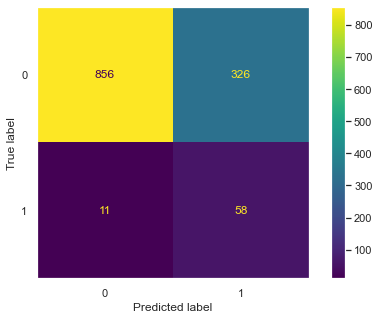

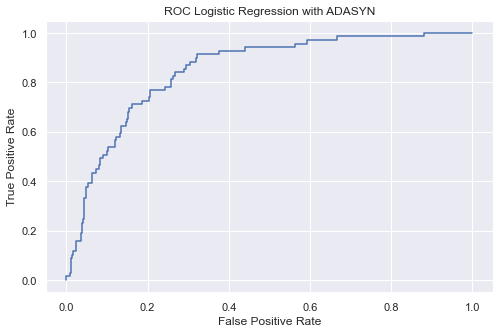

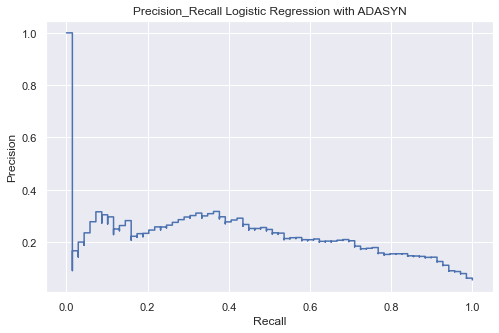

In [27]:
lg = LogisticRegression(random_state = seed)
lg.fit(X_adasyn, y_adasyn)
y_pred = lg.predict(X_test)

confusion_matrix(y_test, y_pred)
ROC_Curve(lg, "Logistic Regression with ADASYN", X_test, y_test, y_pred)
Precision_Recall(lg, "Logistic Regression with ADASYN", X_test, y_test, y_pred)

We found that logistic regression using Borderline SMOTE gives the highest f2 score. We will use the oversampling data from this method

# Model Comparison

In [28]:
#f2 score is the main metric for model comparison
#beta = 2 - weight more on recall
f2 = make_scorer(fbeta_score, beta=2)

def plot_curve(model, title, X, y, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title + ": Learning curve f2")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=f2)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

In [29]:
def model_hypertuning(classifier, params, X_train = X_synthb, y_train = y_synthb,
                             X_test = X_test, y_test = y_test):
    classifier.set_params(**params)
    classifier.fit(X_synthb,y_synthb)
    
    y_pred = classifier.predict(X_test)
    print("Model: ",type(classifier).__name__)
    print("K-Fold Cross Validation Accuracy: %0.2f" % cross_val_score(classifier, X_synthb, y_synthb, scoring = f2, cv = kfold, n_jobs=-1).mean())
    print("Confusion Matrix:")
    confusion_matrix(y_test, y_pred)
    plot_curve(classifier, classifier.__class__.__name__, X_synthb, y_synthb)
    ROC_Curve(classifier, classifier.__class__.__name__, X_test, y_test, y_pred)
    Precision_Recall(classifier,classifier.__class__.__name__, X_test, y_test, y_pred)

In [30]:
#SMOTE Borderline gives the highest f2 score. We choose sampling data from this method
#X_synthb, y_synthb

#For validation - We use Stratified KFold with 7 folds and 3 repetitions
kfold = RepeatedStratifiedKFold(n_splits=7, n_repeats=3)

## Logistic Regression

Model:  LogisticRegression
K-Fold Cross Validation Accuracy: 0.84
Confusion Matrix:


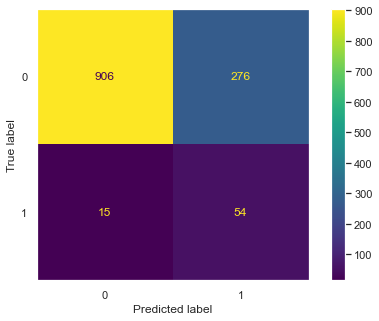

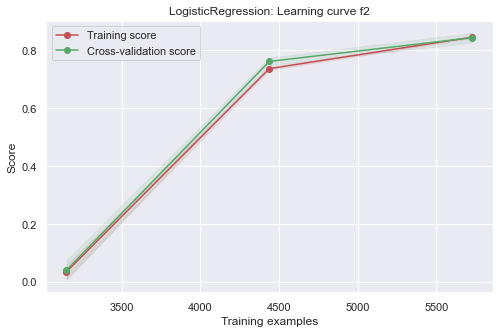


LogisticRegression

Accuracy: 0.77
AUC under ROC: 0.85
AUC under Precison_Recall:0.21
F1: 0.27
F2: 0.45
CPU times: user 354 ms, sys: 129 ms, total: 482 ms
Wall time: 1.52 s


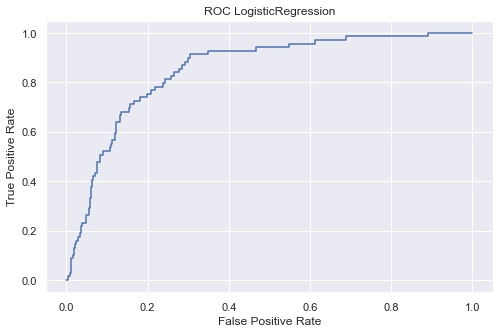

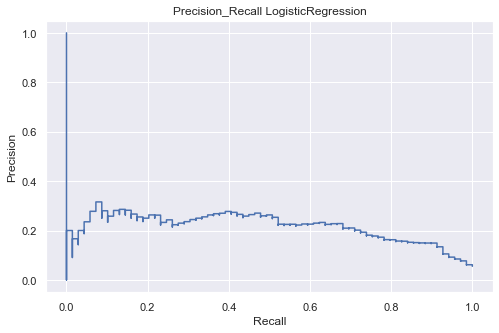

In [31]:
%%time
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
params = dict(solver=solvers,penalty=penalty,C=c_values)
grid_lg = RandomizedSearchCV(lg, params, n_jobs=-1, random_state = seed, cv=kfold)
grid_lg.fit(X_synthb, y_synthb)

model_hypertuning(lg,grid_lg.best_params_)

## Decision Tree

/opt/homebrew/lib/python3.9/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/opt/homebre

Model:  DecisionTreeClassifier
K-Fold Cross Validation Accuracy: 0.94
Confusion Matrix:


/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


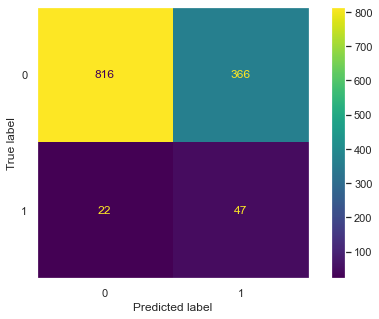

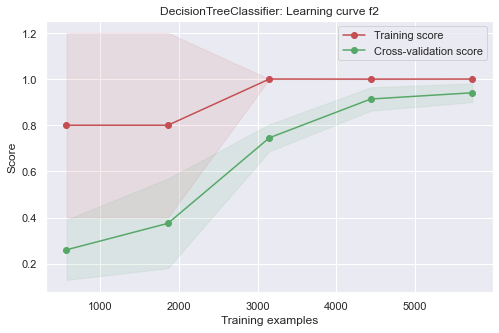


DecisionTreeClassifier

Accuracy: 0.69
AUC under ROC: 0.69
AUC under Precison_Recall:0.41
F1: 0.2
F2: 0.34
CPU times: user 375 ms, sys: 73.3 ms, total: 448 ms
Wall time: 688 ms


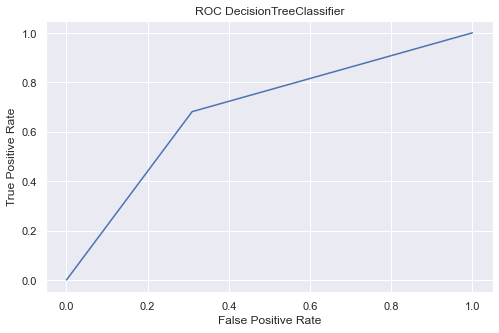

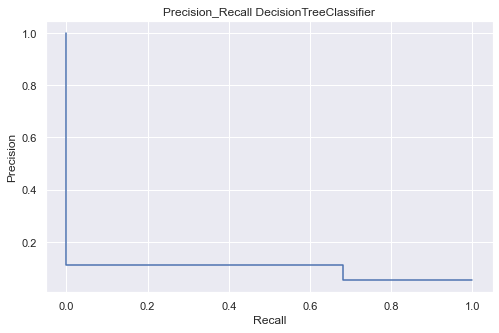

In [32]:
%%time
#hyperparameters tuning
dcc = DecisionTreeClassifier(class_weight = 'balanced', random_state = seed)
params = { 'max_depth' : [3,5,10,15,20,25,30,35,40,45,50],
          'criterion' : ["gini","entropy"],
          'max_features' : ['auto', 'sqrt', 'log2'],
          'min_samples_split' : [2,4,6,8,10]
         }

grid_rcc = RandomizedSearchCV(dcc, params, n_jobs=-1, random_state = seed, cv=kfold)
grid_rcc.fit(X_synthb, y_synthb)

model_hypertuning(dcc,grid_rcc.best_params_)

## Random forest classifier


In [33]:
from pprint import pprint
rf_tune = RandomForestClassifier(class_weight='balanced', random_state=seed)
print('Parameters currently in use:\n')
pprint(rf_tune.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 913,
 'verbose': 0,
 'warm_start': False}


In [34]:
# hyperparametes tuning

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


/opt/homebrew/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for Ran

/opt/homebrew/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for Ran

/opt/homebrew/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for Ran

/opt/homebrew/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for Ran

/opt/homebrew/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for Ran

/opt/homebrew/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for Ran

/opt/homebrew/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for Ran

Model:  RandomForestClassifier


/opt/homebrew/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for Ran

K-Fold Cross Validation Accuracy: 0.97
Confusion Matrix:


/opt/homebrew/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for Ran

/opt/homebrew/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for Ran

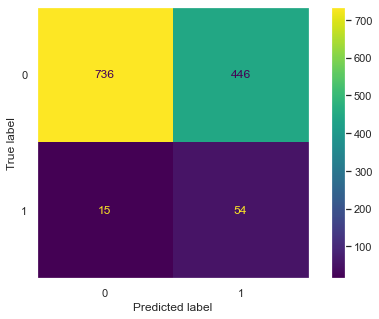

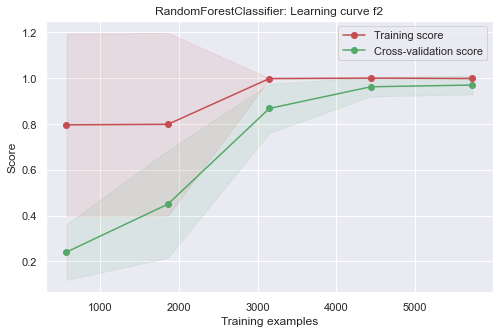


RandomForestClassifier

Accuracy: 0.63
AUC under ROC: 0.75
AUC under Precison_Recall:0.13
F1: 0.19
F2: 0.35
CPU times: user 11.4 s, sys: 298 ms, total: 11.7 s
Wall time: 3min 27s


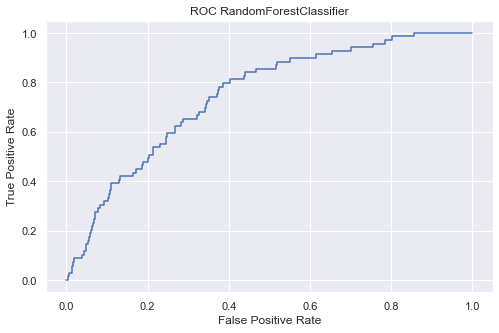

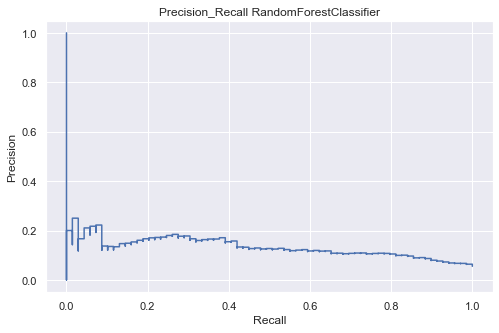

In [35]:
%%time
grid_rf = RandomizedSearchCV(rf_tune, random_grid, n_jobs=-1, random_state = seed, cv=kfold)
grid_rf.fit(X_synthb, y_synthb)

model_hypertuning(rf_tune,grid_rf.best_params_)

## SVM classifier

Model:  SVC
K-Fold Cross Validation Accuracy: 0.92
Confusion Matrix:


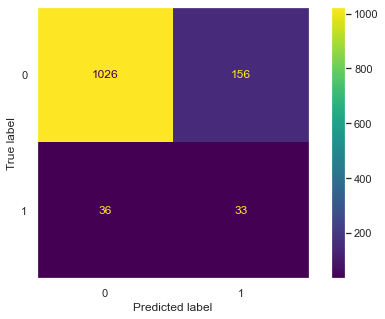

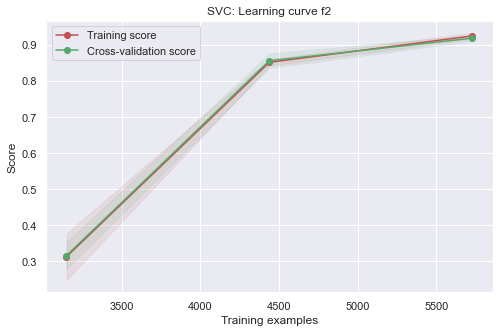


SVC

Accuracy: 0.85
AUC under ROC: 0.76
AUC under Precison_Recall:0.18
F1: 0.26
F2: 0.35
CPU times: user 4.64 s, sys: 217 ms, total: 4.86 s
Wall time: 1min 32s


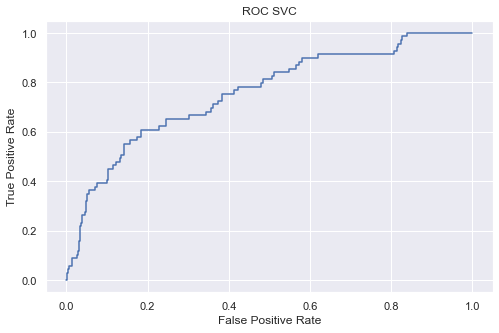

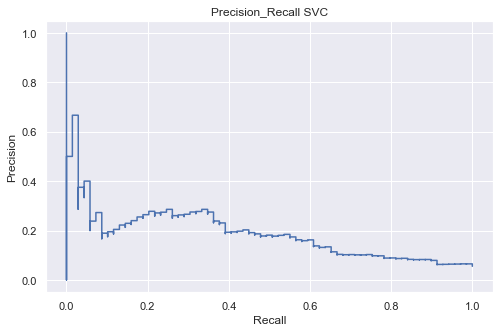

In [36]:
%%time
#hyperparameter tuning 
svc = SVC(probability=True, random_state=seed)
params = { 'kernel' : ['linear','rbf','poly','sigmoid'],
          'C' : [0.1,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5],
          'degree' : [1,2,3,4,5,6]
         }
grid_svc = RandomizedSearchCV(svc, params, n_jobs=-1, random_state = seed, cv=kfold)
grid_svc.fit(X_synthb, y_synthb)

model_hypertuning(svc,grid_svc.best_params_)

## Adaboosting classifier

Model:  AdaBoostClassifier
K-Fold Cross Validation Accuracy: 0.92
Confusion Matrix:


/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


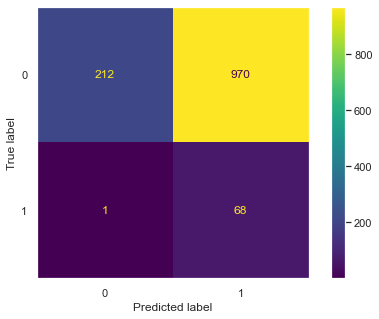

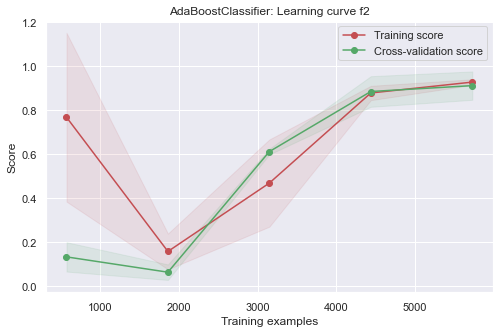


AdaBoostClassifier

Accuracy: 0.22
AUC under ROC: 0.72
AUC under Precison_Recall:0.14
F1: 0.12
F2: 0.26
CPU times: user 13.4 s, sys: 270 ms, total: 13.6 s
Wall time: 3min 17s


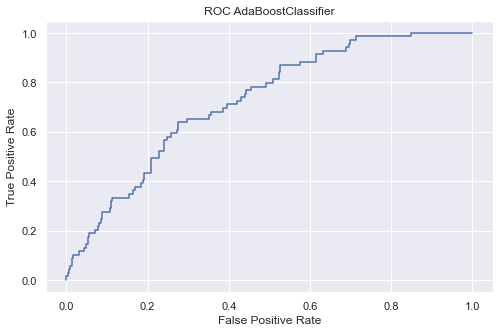

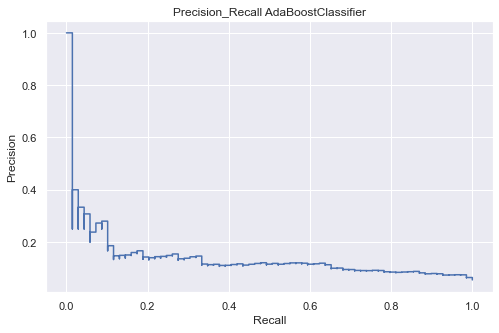

In [37]:
%%time
ada = AdaBoostClassifier(random_state = seed)
params = { 'n_estimators' : [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
          'learning_rate' : [0.05,0.1,0.15,0.2,0.25,0.3]
         }

grid_ada = RandomizedSearchCV(ada, params, n_jobs=-1, random_state = seed, cv=kfold)
grid_ada.fit(X_synthb, y_synthb)

model_hypertuning(ada,grid_ada.best_params_)

In [38]:
elapsed = timeit.default_timer() - start_time
print("Total time to run this notebook: %0.2f" %  elapsed + "s")

Total time to run this notebook: 503.58s
